# Conformers of nerve agents of V-series

## Generation of conformers for docking in Rosetta

In [1]:
# remember to source before using RDkit
# source activate my-rdkit-env 
# and open jupyter from this environment





The script writes out transition state models of the three specified nerve agents. The TS_model contains hydroxide 
attached to the model. 

In [2]:
# angle of attacking hydrogen
ANGLE_HYDROGEN = 112
# P-S bond distance
p_s_dist = 2.50
# Number of conformers
nr_confs = 10 # 500
# RMSD between the generated conformers
rmsd_cutoff = 0.1

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolTransforms as rdmt
import numpy as np
# from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolDrawing, DrawingOptions
from rdkit.Geometry import rdGeometry as geom
import os

In [5]:
def get_conformer_rmsd(mol):
        """
        Calculate conformer-conformer RMSD.
        Parameters
        ----------
        mol : RDKit Mol
            Molecule.
        """
        rmsd = np.zeros((mol.GetNumConformers(), mol.GetNumConformers()),
                        dtype=float)
        for i, ref_conf in enumerate(mol.GetConformers()):
            for j, fit_conf in enumerate(mol.GetConformers()):
                if i >= j:
                    continue
                rmsd[i, j] = AllChem.GetBestRMS(mol, mol, ref_conf.GetId(),
                                                fit_conf.GetId())
                rmsd[j, i] = rmsd[i, j]
        return rmsd

In [6]:
def get_conformer_energies(self, mol):
        """
        Calculate conformer energies.
        Parameters
        ----------
        mol : RDKit Mol
            Molecule.
        Returns
        -------
        energies : array_like
            Minimized conformer energies.
        """
        energies = []
        for conf in mol.GetConformers():
            ff = self.get_molecule_force_field(mol, conf_id=conf.GetId())
            energy = ff.CalcEnergy()
            energies.append(energy)
        energies = np.asarray(energies, dtype=float)
        return energies


In [7]:
def set_new_bond_distance(mol,dist,atm1,atm2,confid=0):
    """
    Set a new bond distance between two atoms
    ----------
    mol : RDKit molecule
    dist : float - new bond distance 
    atm1 : int - idx of atom 1
    atm2 : int - idx of atom 2
    confid : int - conformer from ensemble
    Returns
    ----------
    Mol with new bond length between atom 1 and atom 2
    
    """
    conf = mol.GetConformer(confid)
    rdmt.SetBondLength(conf,atm1,atm2,dist)
    return mol

In [8]:
def set_new_angle(mol,angle,atm1,atm2,atm3,confid=0):
    """
    Set a new angle between three atoms
    ----------
    mol : RDKit molecule
    angle : float - new angle in degrees 
    atm1 : int - idx of atom 1
    atm2 : int - idx of atom 2
    atm3 : int - idx of atom 3
    confid : int - conformer from ensemble
    Returns
    ----------
    Mol with new angle between atom 1, atom 2, atom 3
    
    """
    conf = mol.GetConformer(confid)
    rdmt.SetAngleDeg(conf,atm1,atm2,atm3,angle)
    return mol

In [9]:
def generate_molecule(name,smiles):
    """
    Generate the 3D molecular structure based on input SMILES
    ----------
    name : name of molecule
    smiles: SMILES of molecule
    Returns
    ----------
    Mol 
    
    """
    LIGAND_NAME = name
    m = Chem.MolFromSmiles(smiles)
    m_h = Chem.AddHs(m)
    # Embeed the geometry
    AllChem.EmbedMolecule(m_h, AllChem.ETKDG())
    # Setting name of molecule
    m_h.SetProp("_Name",LIGAND_NAME)
    return m_h

In [10]:
def get_conformers(mol,nr=500,rmsthreshold=0.1):
    """
    Generate 3D conformers of molecule using CSD-method
    ----------
    mol : RKdit molecule
    nr : integer, number of conformers to be generate
    rmsthreshold : float, prune conformers that are less rms away from another conf
    Returns
    ----------
    List of new conformation IDs
    """
    # Generate conformers on the CSD-method
    return AllChem.EmbedMultipleConfs(mol, numConfs=nr,useBasicKnowledge=True,\
                                      pruneRmsThresh=rmsthreshold,useExpTorsionAnglePrefs=True)

## SMILES of the 3 nerve agents:

* VX 

(CCOP(C)(=O)SCC\[NH+\](C(C)C)C(C)C)
* Russian VX (RVX) 

CC\[NH+\](CC)CCSP(=O)(C)OCC(C)C
* Chinese VX (CVX) 

O=P(OCCCC)(SCC\[NH+\](CC)CC)C

### SMILES taken from pubchem except CVX build from RVX

In [11]:
# SMILES from pubchem except CVX build from RVX
# Russian VX : https://pubchem.ncbi.nlm.nih.gov/compound/178033#section=InChI
# VX : https://pubchem.ncbi.nlm.nih.gov/compound/39793
# Chinese VX : https://pubchem.ncbi.nlm.nih.gov/compound/559704
nerve_agents = {'RVX' : 'CC[NH+](CC)CCSP(=O)(C)OCC(C)C',
                'VX'  : 'CCOP(C)(=O)SCC[NH+](C(C)C)C(C)C',
                'CVX' : 'O=P(OCCCC)(SCC[NH+](CC)CC)C'}

In [12]:
#Main of script
# Generate the molecules from SMILES
mols = {}
for name in nerve_agents.keys():
    mols[name] = generate_molecule(name,nerve_agents[name])

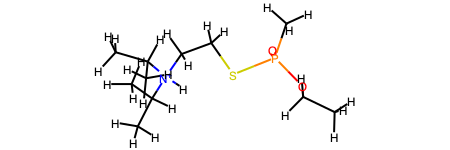

In [13]:
mols['VX']

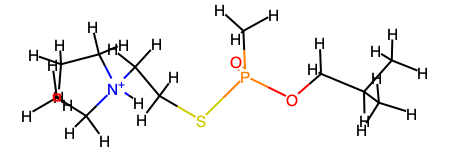

In [14]:
mols['RVX']

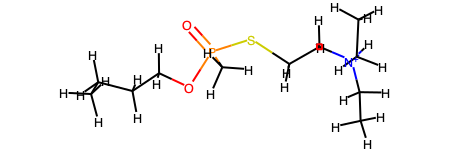

In [15]:
mols['CVX']

# Generation of nucleophile OH-

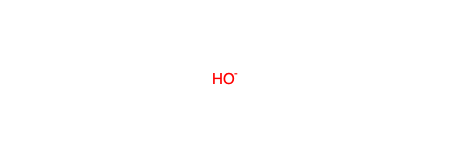

In [16]:
oh = '[OH-]'
oh = Chem.MolFromSmiles(oh,sanitize=True)
oh.SetProp("_Name","OH-")
AllChem.EmbedMolecule(oh, AllChem.ETKDG())
DrawingOptions.includeAtomNumbers=True
oh

In [17]:
def get_carbon_atoms(mol,idx,old_c):
    '''
    
    '''
    for atom in mol.GetAtoms():
        if( atom.GetIdx() == idx ):
            bonds = atom.GetBonds()
            for bnd in bonds:
                tmp_ = bnd.GetOtherAtom(atom)
                if( tmp_.GetSymbol() == 'C' and tmp_.GetIdx() not in old_c):
                    old_c.append( tmp_.GetIdx() )
                    # recursive call for graph
                    get_carbon_atoms(mol,tmp_.GetIdx(), old_c )
                elif( tmp_.GetSymbol() != 'C' ):
                    continue
                else:
                    continue
    return old_c

def get_o_ether_carbon_atoms(mol,poe_idx):
    '''
    
    '''
    poe_carbons = []
    # what are we connected to
    for atom in mol.GetAtoms():
        tmp_atm = atom.GetSymbol()
        
        if(tmp_atm == 'O' and atom.GetIdx() == poe_idx ):
            bonds = atom.GetBonds()
            for bnd in bonds:
                tmp_ = bnd.GetOtherAtom(atom)
                if( tmp_.GetSymbol() == 'C'):
                    poe_carbons.append( tmp_.GetIdx() )
                    tmp_ = tmp_.GetIdx()
                    # get all carbons attached starting with o-ether
                    poe_carbons = get_carbon_atoms(mol, tmp_, poe_carbons)

    return poe_carbons


def get_index_atms(mol):
    """
    get the index of atoms to set geometry
    methyl bonded to phosphorus
    ether bonded to phosphorus
    phosphoryl bonded to phosphorus
    sulfur atom bonded to phosphorus
    hydrogen bonded to nitrogen
    ----------
    mol: RKdit mol
    Returns
    ----------
    index of atoms
    
    """
    
    chiral_atm = {}
    o_groups = []
    for atom in mol.GetAtoms():
        tmp_atm = atom.GetSymbol()
        bonds = atom.GetBonds()
        if(tmp_atm == 'P'):
            p_id = atom.GetIdx()
            for bond in bonds:
                target = bond.GetOtherAtom(atom)
                # methyl group
                if( target.GetSymbol() == 'C'):
                    pc_id = target.GetIdx()
                elif(target.GetSymbol() == 'O'):
                    if(str(bond.GetBondType()) == 'DOUBLE'):
                        po_id = target.GetIdx()
                    else:
                        poe_id = target.GetIdx()
        elif(tmp_atm == 'S'):
            s_id = atom.GetIdx()
        elif(tmp_atm == 'N'):
            for bond in bonds:
                target = bond.GetOtherAtom(atom)
                if( target.GetSymbol() == 'H'): 
                    nh_id = atom.GetIdx()
        else:
            for bond in bonds:
                target = bond.GetOtherAtom(atom)
    return p_id, s_id, pc_id, nh_id, po_id, poe_id

## Setting parameters for the transition state model
### Distance, angles etc

In [18]:
def get_rmsd_after_minimization_conformers(mol,cids):
    '''
    
    '''
    # Do a short minimization and compute the RMSD
    for cid in cids:
        _ = AllChem.MMFFOptimizeMolecule(mol, confId=cid)
    rmslist = []
    AllChem.AlignMolConformers(mol, RMSlist=rmslist)
    return rmslist

def prune_conformers(mol,cids):
    '''
    
    
    '''
    from rdkit.Chem import rdMolTransforms as rdmt
    new = Chem.Mol(mol)
    for cid in cids:
        conf = new.GetConformer(cid)
        # Proton phosphoryl distance
        dist = rdmt.GetBondLength(conf, nh_id, po_id)
        # remove conformers
        if(dist <= 2.3):
            new.RemoveConformer(cid)
    conf_ids = [conf.GetId() for conf in new.GetConformers()]
    dummy = 1
    for m in conf_ids:
        w = Chem.SDWriter('prune'+str(dummy)+'.sdf')
        w.write(new,confId=m)
        dummy += 1

        
def get_ts_geom(m,p_s_dist, p_id, s_id, poe_id, pc_id ):
    '''
    
    
    '''
    plane_angle = 120
    off_plane = 90
    # P-S bond distance is set here
    m = set_new_bond_distance(m,p_s_dist,p_id,s_id)
    # setting o-ethyl group
    m = set_new_angle(m,90, s_id, p_id, poe_id)
    # setting methyl-group
    m = set_new_angle(m,90,s_id,p_id,pc_id)
    # setting phosphoryl 
    m = set_new_angle(m,90,s_id,p_id,po_id)
    # Setting plane angle to 120 degrees
    m = set_new_angle(m,120,poe_id,p_id,pc_id)
    m = set_new_angle(m,120,po_id,p_id,pc_id)
    # conformers
    conf = m.GetConformer(0)
    # Proton sulfur distance
    dst1 = rdmt.GetBondLength(conf, po_id, nh_id)
    if(dst1 > 3.0 ):
        return m
    else:
        return 


def get_transition_state_geometry(dist):
    '''
    ----------
    dist: float, bond breaking distance
    
    Returns
    ----------
    index of atoms
    '''
    import os
    fls = os.listdir('.')
    s_isomers = []
    r_isomers = []
    k = True
    
    for fl in fls:
        if(fl.startswith('prune')):
            m = Chem.MolFromMolFile(fl, True, False)
            Chem.AssignAtomChiralTagsFromStructure(m)
            tmp =  Chem.FindMolChiralCenters(m, includeUnassigned=True)
            
            if(tmp[0][1] == 'S'):
                m =  get_ts_geom(m,p_s_dist, p_id, s_id, poe_id, pc_id )
                if(m != None):
                    s_isomers.append(m)
            elif(tmp[0][1] == 'R'):
                m =  get_ts_geom(m,p_s_dist, p_id, s_id, poe_id, pc_id )
                if(m != None):
                    r_isomers.append(m)
            else:
                print("Error")
    return s_isomers, r_isomers

In [19]:
def write_transition_states_isomers_to_file(dist,list_of_isomers,isomer="S"):
    '''
    
    '''
    dummy = 1
    for test in s_isomers:
        writer3 = Chem.SDWriter(isomer+'_'+LIGAND_NAME+'_'+str(dist)+'_'+str(dummy)+'.sdf')
        writer3.write(test,confId=0)
        dummy += 1
    writer3.close()

In [20]:
def write_aligned_to_file(list_of_confs, atoms_to_match=(8,9,10,11),filename='Aligned.sdf' ):
    aligned = None
    aligned =  list_of_confs[0]
    tmp_length_ = len(list_of_confs)
    for i in range(tmp_length_):
        aligned.AddConformer(list_of_confs[i].GetConformer(0),assignId=True)   
    conf_ids = [conf.GetId() for conf in aligned.GetConformers()]
    rmslst = []
    AllChem.AlignMolConformers(aligned, atomIds=atoms_to_match, RMSlist=rmslst)
    
    for i in  conf_ids:
        writer3 = Chem.SDWriter(filename+"_"+str(i)+".sdf")
        writer3.write(aligned,confId=i)
    return aligned

In [21]:
def get_index_dummy_atms(mol):
    """
    get the index of atoms to set geometry
    methyl bonded to phosphorus
    ether bonded to phosphorus
    phosphoryl bonded to phosphorus
    sulfur atom bonded to phosphorus
    hydrogen bonded to nitrogen
    ----------
    mol: RKdit mol
    Returns
    ----------
    index of atoms
    
    """
    
    dmm = []
    for atom in mol.GetAtoms():
        back = Chem.RWMol(mol)
        tmp_atm = atom.GetSymbol()
        bonds = atom.GetBonds()
        if(tmp_atm == '*'):
            dmm.append(atom.GetIdx() )
    
    dmm.sort(reverse=True)
    for idx in dmm:
            back.RemoveAtom(idx)
    return back

# Add OH- to transition state model

In [22]:
OH_INDEX_OXYGEN = 0
OH_INDEX_HYDROGEN = 0

def get_index_of_nucleophile(combo):
    '''
    
    '''
    o_hydroxide = 0
    for atom in combo.GetAtoms():
        bonds = atom.GetBonds()
        for bond in bonds:
            target = bond.GetOtherAtom(atom)
            if(target.GetSymbol() == 'H' and atom.GetSymbol() == 'O'):
                o_hydroxide = atom.GetIdx()
                h_hydroxide = target.GetIdx()
    return o_hydroxide, h_hydroxide



# setup and generate transition states
def add_hydroxide_to_transition_state_model(nucleophile,p_id,s_id,conformer,o_ether_idx,bond_increase=1.9):
    '''
    
    
    '''
    # get directional vector from phosphorus and sulfur atom
    p_vec = np.array(conformer.GetConformer(0).GetAtomPosition(p_id))
    s_vec = np.array(conformer.GetConformer(0).GetAtomPosition(s_id))
    sp_vec = (p_vec - s_vec) / np.linalg.norm(p_vec - s_vec) * bond_increase + p_vec
    tmp_ = geom.Point3D(sp_vec[0],sp_vec[1],sp_vec[2]) 
    nucleophile.GetConformer().SetAtomPosition(0,tmp_)
    # Hydrogen is removed and add later
    nucleophile = Chem.RemoveHs(nucleophile)
    nucleophile = Chem.AddHs(nucleophile,addCoords=True)
    # combine molecule
    combo = Chem.CombineMols(conformer, nucleophile)        
    # get new index of oxygen of hydroxide
    o_hydroxide, h_hydroxide = get_index_of_nucleophile(combo)
    
    OH_INDEX_OXYGEN = o_hydroxide
    OH_INDEX_HYDROGEN = h_hydroxide
    
    
    edcombo = Chem.EditableMol(combo)
    edcombo.AddBond(p_id,o_hydroxide,order=Chem.rdchem.BondType.SINGLE)      
    back = edcombo.GetMol()
    ## p_id, s_id = get_index_atms_hydroxide(m)
    bond = back.GetBondBetweenAtoms(p_id, s_id)
    back = Chem.FragmentOnBonds(back, [bond.GetIdx()], addDummies=True, dummyLabels=[(1, 1)])

    atom1 = back.GetAtomWithIdx(OH_INDEX_OXYGEN)
    atom1.SetFormalCharge(0)
    Chem.SanitizeMol(back)
    rdmt.SetAngleDeg(back.GetConformer(0),p_id,OH_INDEX_OXYGEN,OH_INDEX_HYDROGEN,ANGLE_HYDROGEN)
    
    ########## REMOVE ATOMS
    back = get_index_dummy_atms(back)
    
    # Add bond between P-S
    edcombo = Chem.EditableMol(back)
    edcombo.AddBond(p_id,s_id,order=Chem.rdchem.BondType.SINGLE)      
    back = edcombo.GetMol()
    
    # get distance constraints
    # o_ether_idx
    for i in o_ether_idx:
        dst1 = rdmt.GetBondLength(back.GetConformer(0), i, o_hydroxide)
        # 2.4 Å is approximately covalent distance range
        if(dst1 < 2.4 ):
            return -1
    return back



# Setup transition state with hydroxide
def write_hydroxide_transition_state_model(oh,molecule_name,isomer_name,o_ether_idx):
    '''
    
    '''
    # Get x,y,z position of oxygen atom of hydroxide
    pos = oh.GetConformer().GetAtomPosition(0)
    prefix_ = "TS_model"
    fls = os.listdir('.')
    # Identify 
    ## molecule+"_R_aligned_isomers"
    id_fl = molecule_name+"_"+isomer_name+"_aligned_isomers"
    for fl in fls:
        if(fl.startswith(id_fl)):
            conformer= Chem.MolFromMolFile(fl, True, False)
            new_ts_model = add_hydroxide_to_transition_state_model(oh,p_id,s_id, conformer,o_ether_idx)
            if(new_ts_model != -1):
                writer3 = Chem.SDWriter(prefix_+"_"+fl)
                writer3.write(new_ts_model,confId=0)

Setting the geometrical parameters for the transition state based on QM or empirical finds. 

In [23]:

# setup generation of conformers
for molecule in mols.keys():
    # Name of ligand
    LIGAND_NAME = molecule
    # Generate conformers for each molecule
    cids = get_conformers(mols[molecule], nr_confs, rmsd_cutoff)
    # Get index of atoms used to build molecule
    p_id, s_id, pc_id, nh_id, po_id, poe_id = get_index_atms( mols[molecule] )
    
    ### TEST TEST ###
    o_ether_idx = get_o_ether_carbon_atoms(mols[molecule],poe_id)
    
    rmslist = get_rmsd_after_minimization_conformers(mols[molecule],cids)
    # Assign chiral centers to molecule
    Chem.FindMolChiralCenters(mols[molecule], p_id, includeUnassigned=True)
    # Remove conformers based on N-H ... P=O distance
    prune_conformers(mols[molecule],cids)
    #
    s_isomers, r_isomers = get_transition_state_geometry(p_s_dist)
    print("Number of conformers for S-"+str(molecule)+" : "+str(len(s_isomers)))
    print("Number of conformers for R-"+str(molecule)+" : "+str(len(r_isomers)))
    # write to file
    write_aligned_to_file(r_isomers,(p_id,po_id,poe_id,pc_id),molecule+"_R_aligned_isomers")
    write_aligned_to_file(s_isomers,(p_id,po_id,poe_id,pc_id),molecule+"_S_aligned_isomers")
    # Remove pruned conformers
    !rm prune*sdf
    # setup and add nucleophile to transition state model
    write_hydroxide_transition_state_model(oh, molecule, 'R',o_ether_idx)
    write_hydroxide_transition_state_model(oh, molecule, 'S',o_ether_idx)

Number of conformers for S-RVX : 2
Number of conformers for R-RVX : 2
Number of conformers for S-VX : 2
Number of conformers for R-VX : 3
Number of conformers for S-CVX : 4
Number of conformers for R-CVX : 3


# Setting the geometry of the attacking hydrogen of the hydroxide

In [24]:
def get_index_atms_hydroxide(mol):
    """
    get the index of atoms to set geometry
    methyl bonded to phosphorus
    ether bonded to phosphorus
    phosphoryl bonded to phosphorus
    sulfur atom bonded to phosphorus
    hydrogen bonded to nitrogen
    ----------
    mol: RKdit mol
    Returns
    ----------
    index of atoms
    
    """
    for atom in mol.GetAtoms():
        tmp_atm = atom.GetSymbol()
        bonds = atom.GetBonds()
        if(tmp_atm == 'P'):
            p_id = atom.GetIdx()
        elif(tmp_atm == 'S'):
            s_id = atom.GetIdx()    
    return p_id, s_id


def get_index_dummy_atms(mol):
    """
    get the index of atoms to set geometry
    methyl bonded to phosphorus
    ether bonded to phosphorus
    phosphoryl bonded to phosphorus
    sulfur atom bonded to phosphorus
    hydrogen bonded to nitrogen
    ----------
    mol: RKdit mol
    Returns
    ----------
    index of atoms
    
    """
    dmm = []
    for atom in mol.GetAtoms():
        tmp_atm = atom.GetSymbol()
        bonds = atom.GetBonds()
        if(tmp_atm == 'R'):
            dmm.append( atom.GetIdx() )
    return dmm

In [25]:
# Setup transition state with hydroxide
def set_angle_hydroxide(angle_size):
    prefix_ = "TS_model"
    fls = os.listdir('.')
    for fl in fls:
        if(fl.startswith(prefix_)):
            m = Chem.MolFromMolFile(fl, False, False, False)
            # get index of atoms:::
            p_id, s_id = get_index_atms_hydroxide(m)
            bond = m.GetBondBetweenAtoms(p_id, s_id)
            new_m = Chem.FragmentOnBonds(m, [bond.GetIdx()], addDummies=True, dummyLabels=[(1, 1)])
            
            #Chem.SanitizeMol(new_m)
            #rdmt.SetAngleDeg(new_m.GetConformer(0),p_id,OH_INDEX_OXYGEN,OH_INDEX_HYDROGEN,angle)
            edcombo = Chem.EditableMol(new_m)
            edcombo.AddBond(p_id,s_id,order=Chem.rdchem.BondType.SINGLE) 
            back = edcombo.GetMol()
            dmm = get_index_dummy_atms(back)
            for dm in dmm:
                edcombo.RemoveAtom(dm)

            writer3 = Chem.SDWriter("FIXED_"+fl)
            writer3.write(edcombo.GetMol(),confId=0)